In [16]:
import scipy.io as sio
from matplotlib import pyplot as plt 
%matplotlib inline

from mne.viz import plot_compare_evokeds

import numpy as np 

import os 
from andante_pd_ft2mne import import2mne  

matfile = '/Users/nicolasfarrugia/Documents/recherche/PD/PDNewAnalysis/data/eeg_task/analysis/data_newfilt/probands/data_cleaned_newfilt_subj_01k101k1.mat'


Test on all subjects 
--

In [2]:
datadir = '/Users/nicolasfarrugia/Documents/recherche/PD/PDNewAnalysis/data/eeg_task/analysis/data_newfilt/'

import os 

allcontrols = os.listdir(os.path.join(datadir,'probands'))
allpatients = os.listdir(os.path.join(datadir,'patients'))

if not(os.path.isdir('timegen_controls_wholeepoch')):
    print('Making probands timegen dir ')
    os.mkdir('timegen_controls_wholeepoch')

if not(os.path.isdir('timegen_patients_wholeepoch')):
    print('Making patients timegen dir ')
    os.mkdir('timegen_patients_wholeepoch')

In [38]:
from andante_pd_ft2mne import import2mne  
from mne import Epochs,EpochsArray
from mne.channels import read_montage

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

import mne
from mne.datasets import sample
from mne.decoding import GeneralizingEstimator
from mne.decoding import CSP

from sklearn.model_selection import StratifiedKFold


def timegen_process_2x2(matfile,ncv=5,metric='accuracy',tmin=-0.05,tmax=0.15,
                        condnames=['iso_std','iso_dev'],condnames_2=['rnd_std','rnd_dev']):
    subjid = matfile[-8:-4]
    print("Subject : %s " % subjid)
    
    ## Open file 
    mneEpochs = import2mne(matfile)
    mneEpochs_short = mneEpochs.crop(tmin=tmin,tmax=tmax)
    
    
    montage = read_montage('standard_1020')

    mneEpochs_short.set_montage(montage)

    ## Perform Supervised Learning using Temporal Generalization 
    
    epochs = mneEpochs_short[condnames]
    epochs_cond2 = mneEpochs_short[condnames_2]
    
    clf = make_pipeline(StandardScaler(),LogisticRegression())

    time_gen = GeneralizingEstimator(clf, scoring=metric, n_jobs=1)

    time_gen_cond2 = GeneralizingEstimator(clf, scoring=metric, n_jobs=1)

    
    # Get the labels
    labels = epochs.events[:, -1]
    labels_2 = epochs_cond2.events[:, -1]

    # Cross validator
    cv = StratifiedKFold(n_splits=ncv, shuffle=True, random_state=42)

    
    ### We will calculate a 2x2 matrix
    ### First, let's cal
    
    
    scores1_1 = []
    scores1_2 = []

    scores2_1 = []
    scores2_2 = []

    
    for train, test in cv.split(epochs, labels):
        for train2, test2 in cv.split(epochs_cond2,labels_2):

            # Train classifier1 on train data of condition 1 
            time_gen.fit(X=epochs[train].get_data(), y=labels[train])

            # Train classifier2 on train data of condition 2 
            time_gen_cond2.fit(X=epochs_cond2[train2].get_data(), y=labels_2[train2])
            
            # Test Classifier1 on test data of condition 1
            scores1_1.append(time_gen.score(X=epochs[test].get_data(),y=labels[test]))

            # Test Classifier1 on test data of condition 2
            scores1_2.append(time_gen.score(X=epochs_cond2[test2].get_data(),y=labels_2[test2]))
            
            # Test Classifier2 on test data of condition 1
            scores2_1.append(time_gen_cond2.score(X=epochs[test].get_data(),y=labels[test]))

            # Test Classifier2 on test data of condition 2
            scores2_2.append(time_gen_cond2.score(X=epochs_cond2[test2].get_data(),y=labels_2[test2]))

        
    scores1_1 = np.stack(scores1_1)
    
    scores1_2 = np.stack(scores1_2)
    
    scores2_1 = np.stack(scores2_1)
    
    scores2_2 = np.stack(scores2_2)
    
    return scores1_1,scores1_2,scores2_1,scores2_2,epochs.times[[0, -1, 0, -1]]

Formal structure

In [ ]:
temporal = ['iso_std','rnd_std']
formal_iso = ['iso_std','iso_dev']
formal_rnd = ['rnd_std','rnd_dev']

tmin = -0.05
tmax = 0.52

#tmin = 0.10
#tmax = 0.20

ncv  = 2

In [48]:
allscores_formal = []

for matfile in allcontrols:
    curfile = os.path.join(datadir,'probands',matfile)
    subjid = curfile[-8:-4]
    
    sc1_1,sc1_2,sc2_1,sc2_2,timepoints= timegen_process_2x2(curfile,metric='roc_auc',tmin=tmin,tmax=tmax,
                                             ncv=ncv,condnames=formal_iso,condnames_2=formal_rnd)
    
    allscores_formal.append([sc1_1,sc1_2,sc2_1,sc2_2])
    

Subject : 01k1 
657 matching events found
0 projection items activated
0 bad epochs dropped
Subject : 02k1 
612 matching events found
0 projection items activated
0 bad epochs dropped
Subject : 03k1 
621 matching events found
0 projection items activated
0 bad epochs dropped
Subject : 04k1 
670 matching events found
0 projection items activated
0 bad epochs dropped
Subject : 05k1 
613 matching events found
0 projection items activated
0 bad epochs dropped
Subject : 06k1 
562 matching events found
0 projection items activated
0 bad epochs dropped
Subject : 07k1 
631 matching events found
0 projection items activated
0 bad epochs dropped
Subject : 08k1 
587 matching events found
0 projection items activated
0 bad epochs dropped
Subject : 09k1 
574 matching events found
0 projection items activated
0 bad epochs dropped
Subject : 10k1 
671 matching events found
0 projection items activated
0 bad epochs dropped
Subject : 11k1 
679 matching events found
0 projection items activated
0 bad epo

In [50]:
allscores_formal = np.stack(allscores_formal)

np.savez_compressed("180513_allscores_formal_conditionwise.npz",allscores_formal=allscores_formal)

In [111]:
def plot_2x2(matfile,scores1_1,scores1_2,scores2_1,scores2_2,timepoints,metric='accuracy',tmin=-0.05,tmax=0.15,
                        condnames=['iso_std','iso_dev'],condnames_2=['rnd_std','rnd_dev']):
    
    subjid = matfile[-8:-4]
    
    ## Open file 
    mneEpochs = import2mne(matfile)
    mneEpochs_short = mneEpochs.crop(tmin=tmin,tmax=tmax)
    
    
    montage = read_montage('standard_1020')

    mneEpochs_short.set_montage(montage)
    
    
    #Plot
    
    fig, axes = plt.subplots(nrows=2, ncols=2)
    
    axes_order = [(1,0),(1,1),(0,0),(0,1)]
    
    
    yaxis_names = ['Training Regular','','Training Irregular','']
    xaxis_names = ['Testing Regular','Testing Irregular','','']

    
    for cur_ind,scores in enumerate([scores1_1,scores1_2,scores2_1,scores2_2]):
    
        cur_ax = axes[axes_order[cur_ind]]
        
        im = cur_ax.matshow(scores.mean(axis=0), cmap='RdBu_r', vmin=0.3,vmax=0.7,origin='lower',
                    extent=timepoints)

        cur_ax.axhline(0., color='k')
        cur_ax.axvline(0., color='k')
        cur_ax.xaxis.set_ticks_position('bottom')
        cur_ax.set_xlabel(xaxis_names[cur_ind])
        cur_ax.set_ylabel(yaxis_names[cur_ind])
        #titlestring = sprintf("%s - %s \n %s vs %s",subjid,metric,condnames[0],condnames[1])
        #cur_ax.set_title('%s - %s - \n %s vs %s' % (subjid,metric,allcondnames[(0+2*cur_ind)%4],allcondnames[(2*cur_ind+1)%4]))
        #cur_ax.set_title('%d' % cur_ind)
        #plt.colorbar(im, ax=cur_ax)
    
    """## Plot the ERP """
    """
    colors = ['Crimson','CornFlowerBlue']

    pick = mneEpochs_short.ch_names.index('Cz')
    
    
    conditions = condnames

    evoked_dict = dict()
    for condition in conditions:
        evoked_dict[condition] = mneEpochs_short[condition].average()
        

    plot_compare_evokeds(evoked_dict,colors=colors,picks=pick,axes=axes[1,2])
    
    
    conditions2 = condnames_2

    evoked_dict2 = dict()
    for condition in conditions2:
        evoked_dict2[condition] = mneEpochs_short[condition].average()

    plot_compare_evokeds(evoked_dict2,colors=colors,picks=pick,axes=axes[0,2])

    

    """
    fig.subplots_adjust(wspace=0.1)
    
    return fig

In [113]:
if not(os.path.isdir('timegen_controls_conditionwise')):
    print('Making probands conditionwise dir ')
    os.mkdir('timegen_controls_conditionwise')

for jj,matfile in enumerate(allcontrols):
    curfile = os.path.join(datadir,'probands',matfile)
    subjid = curfile[-8:-4]
    
    
    fig= plot_2x2(curfile,allscores_formal[jj,0],allscores_formal[jj,1],allscores_formal[jj,2],allscores_formal[jj,3],
                  timepoints,metric='roc_auc',tmin=tmin,tmax=tmax,
                                             condnames=formal_iso,condnames_2=formal_rnd)
    
    
    fig.set_size_inches([8.,8.])
    fig.savefig('timegen_controls_conditionwise/%s_formal.png' % subjid)
    plt.close(fig)

657 matching events found
0 projection items activated
0 bad epochs dropped
612 matching events found
0 projection items activated
0 bad epochs dropped
621 matching events found
0 projection items activated
0 bad epochs dropped
670 matching events found
0 projection items activated
0 bad epochs dropped
613 matching events found
0 projection items activated
0 bad epochs dropped
562 matching events found
0 projection items activated
0 bad epochs dropped
631 matching events found
0 projection items activated
0 bad epochs dropped
587 matching events found
0 projection items activated
0 bad epochs dropped
574 matching events found
0 projection items activated
0 bad epochs dropped
671 matching events found
0 projection items activated
0 bad epochs dropped
679 matching events found
0 projection items activated
0 bad epochs dropped
685 matching events found
0 projection items activated
0 bad epochs dropped
633 matching events found
0 projection items activated
0 bad epochs dropped
637 matching

In [115]:
if not(os.path.isdir('timegen_patients_conditionwise')):
    print('Making patients conditionwise dir ')
    os.mkdir('timegen_patients_conditionwise')

allscores_formal_pat = []

for matfile in allpatients:
    curfile = os.path.join(datadir,'patients',matfile)
    subjid = curfile[-8:-4]
    
    sc1_1,sc1_2,sc2_1,sc2_2,timepoints= timegen_process_2x2(curfile,metric='roc_auc',tmin=tmin,tmax=tmax,
                                             ncv=ncv,condnames=formal_iso,condnames_2=formal_rnd)
    
    fig= plot_2x2(curfile,sc1_1,sc1_2,sc2_1,sc2_2,
                  timepoints,metric='roc_auc',tmin=tmin,tmax=tmax,
                                             condnames=formal_iso,condnames_2=formal_rnd)
    
    
    fig.set_size_inches([8.,8.])
    fig.savefig('timegen_patients_conditionwise/%s_formal.png' % subjid)
    plt.close(fig)
    
    
    allscores_formal_pat.append([sc1_1,sc1_2,sc2_1,sc2_2])

allscores_formal_pat = np.stack(allscores_formal_pat)

np.savez_compressed("180513_allscores_formal_patients_conditionwise.npz",allscores_formal=allscores_formal_pat)

Subject : 01c1 
632 matching events found
0 projection items activated
0 bad epochs dropped
632 matching events found
0 projection items activated
0 bad epochs dropped
Subject : 01m1 
566 matching events found
0 projection items activated
0 bad epochs dropped
566 matching events found
0 projection items activated
0 bad epochs dropped
Subject : 02c1 
577 matching events found
0 projection items activated
0 bad epochs dropped
577 matching events found
0 projection items activated
0 bad epochs dropped
Subject : 02m1 
608 matching events found
0 projection items activated
0 bad epochs dropped
608 matching events found
0 projection items activated
0 bad epochs dropped
Subject : 03c1 
639 matching events found
0 projection items activated
0 bad epochs dropped
639 matching events found
0 projection items activated
0 bad epochs dropped
Subject : 03m1 
654 matching events found
0 projection items activated
0 bad epochs dropped
654 matching events found
0 projection items activated
0 bad epochs 

In [80]:
def thresholding(matrix_all,thr=0.65):
    result = np.zeros_like(matrix_all[0])
    mask = np.zeros_like(matrix_all[0])
    
    for curmat in matrix_all:
        mask[curmat>thr] = 1
        result += mask
    return result

In [170]:
def mat_view(curmat,ext,ax1,fig):

    #fig, (ax1) = plt.subplots(ncols=1)
    
    im = ax1.matshow(curmat, figure = fig,cmap='hot', vmin=0,vmax=20,origin='lower',extent = ext)
    ax1.axhline(0., color='k')
    ax1.axvline(0., color='k')
    ax1.xaxis.set_ticks_position('bottom')
    ax1.set_xlabel('Testing Time (s)')
    ax1.set_ylabel('Training Time (s)')
    plt.colorbar(im, ax=ax1)
    #return fig,ax1

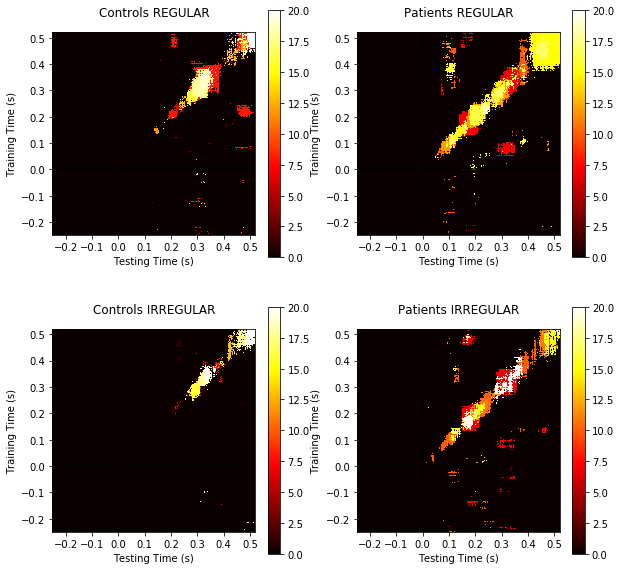

In [176]:
fig=plt.figure(figsize=(10,10))
ax = plt.subplot(2,2,1)
thresh = 0.72


mat_view(thresholding(formal_iso_controls,thr=thresh),ext = epochsextent,ax1=ax,fig=fig)
plt.title('Controls REGULAR')

ax=plt.subplot(2,2,2)
mat_view(thresholding(formal_iso_patients,thr=thresh),ext = epochsextent,ax1=ax,fig=fig)
plt.title('Patients REGULAR')

ax=plt.subplot(2,2,3)
mat_view(thresholding(formal_rnd_controls,thr=thresh),ext = epochsextent,ax1=ax,fig=fig)
plt.title('Controls IRREGULAR')

ax=plt.subplot(2,2,4)
mat_view(thresholding(formal_rnd_patients,thr=thresh),ext = epochsextent,ax1=ax,fig=fig)
plt.title('Patients IRREGULAR')

plt.show()
